In [1]:
import numpy as np
import mne
import pickle
import sys
import os

# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(BASE_DIR)
%matplotlib inline
mne.utils.set_config('MNE_USE_CUDA', 'true')  
mne.cuda.init_cuda(verbose=True)

Now using CUDA device 0
Enabling CUDA with 448.4 MB available memory


In [2]:
#Load transformed data from saved file into list
data=pickle.load(open('pickled/OpenBCISession_2020-02-07_11-12-39-FIVE', 'rb'))

In [3]:
#Naming system for blocks into integers
bloc={
    "sync":1,
    "baseline":2,
    "stressor":3,
    "survey":4,
    "rest":5,
    "slowBreath":6,
    "paced":7
}

def createMNEObj(data, name='Empty'):
    #Create Metadata
    
    sampling_rate = 125
    channel_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4',
                    'time', 'bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate', 'segment_indices1', 'segment_indices2', 'block']
    channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 
                     'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'stim']
    n_channels = len(channel_types)
    info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=channel_types)
    info['description'] = name
    print(info)
    transformed = []
    start=-1.0
    
    for i in range(len(data)):
        add=[]
        add=data[i][1:17]
#         print(data[i][19].keys())
        if start==-1:
            start=data[i][18].hour*3600 + data[i][18].minute*60 + data[i][18].second + data[i][18].microsecond/1000
            add.append(0.0)
        else:
            tim=data[i][18].hour*3600 + data[i][18].minute*60 + data[i][18].second + data[i][18].microsecond/1000
            add.append(tim-start)
#         add.append(str(data[i][18].hour)+':'+str(data[i][18].minute)+':'+str(data[i][18].second)+':'+str(int(data[i][18].microsecond/1000)))
#         try:
        add.append(data[i][19]['bpm'])
#         except Exception as e: 
#             print(e, i)
#             print(data[i][19])
#             print(len(data))
        
        add.append(data[i][19]['ibi'])
        add.append(data[i][19]['sdnn'])
        add.append(data[i][19]['sdsd'])
        add.append(data[i][19]['rmssd'])
        add.append(data[i][19]['pnn20'])
        add.append(data[i][19]['pnn50'])
        add.append(data[i][19]['hr_mad'])
        add.append(data[i][19]['sd1'])
        add.append(data[i][19]['sd2'])
        add.append(data[i][19]['s'])
        add.append(data[i][19]['sd1/sd2'])
        add.append(data[i][19]['breathingrate'])
        add.append(data[i][19]['segment_indices'][0])
        add.append(data[i][19]['segment_indices'][1])
        add.append(bloc[data[i][20]])
        transformed.append(np.array(add))
    
    transformed=np.array(transformed)
    print(transformed[0])
    #have to convert rows to columns to fit MNE structure
    transformed=transformed.transpose()
    print(transformed[0], transformed[1], transformed[2], transformed[3])
    print(len(transformed[0]))
    loaded=mne.io.RawArray(transformed, info)
    return loaded

In [4]:
raw=createMNEObj(data)

<ipython-input-3-f7810211a598>:21: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['segment_indices1', 'segment_indices2']
  info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=channel_types)
<ipython-input-3-f7810211a598>:21: RuntimeWarning: Channel names are not unique, found duplicates for: {'segment_indices'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=channel_types)
/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Warning: converting a masked element to nan.


<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, C3, C4, P7, P8, O1, O2, F7, ...
    chs : list | 33 items (EEG: 16, MISC: 16, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 5 items
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 62.5 Hz
    meas_date : NoneType | unspecified
    nchan : int | 33
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 125.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_nam

In [5]:
# montage = mne.channels.read_custom_montage('./cap.txt')
montage = mne.channels.make_standard_montage('easycap-M1')

In [6]:
raw.set_montage(montage, raise_if_subset=False)

DigMontage is a superset of info. 58 in DigMontage will be ignored. The ignored channels are: {'FC5', 'FT9', 'P10', 'PO3', 'TP8', 'FC1', 'P6', 'FC4', 'PO4', 'F2', 'CP3', 'PO10', 'O10', 'PO7', 'TP7', 'AFz', 'Pz', 'AF8', 'PO9', 'CP4', 'CP6', 'O9', 'POz', 'CP2', 'FC6', 'FT8', 'FC2', 'CPz', 'P2', 'F10', 'C2', 'AF4', 'FCz', 'C5', 'C6', 'TP9', 'CP1', 'FC3', 'CP5', 'P9', 'F1', 'TP10', 'P1', 'F5', 'FT10', 'Fpz', 'AF7', 'C1', 'PO8', 'Iz', 'P5', 'FT7', 'F6', 'AF3', 'Cz', 'Oz', 'Fz', 'F9'}


<RawArray  |  None, n_channels x n_times : 33 x 201118 (1608.9 sec), ~50.7 MB, data loaded>

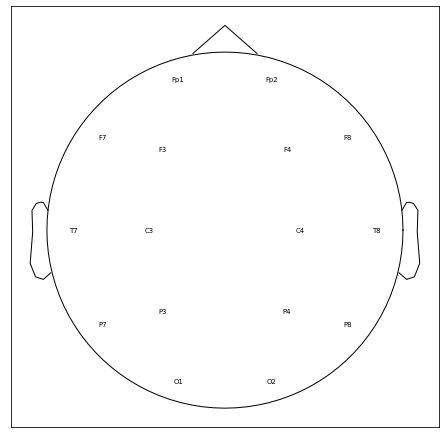

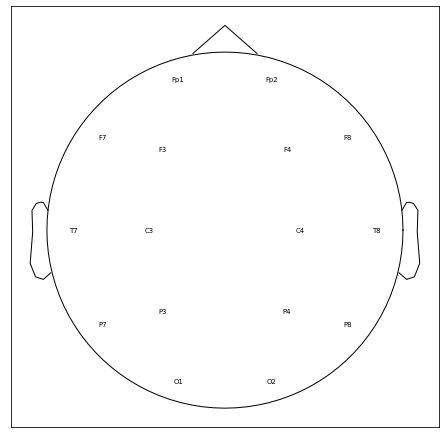

In [7]:
layout = mne.channels.read_layout('cap', path='./')
layout.plot()  # same result as: mne.viz.plot_layout(biosemi_layout)

Effective window size : 16.384 (s)


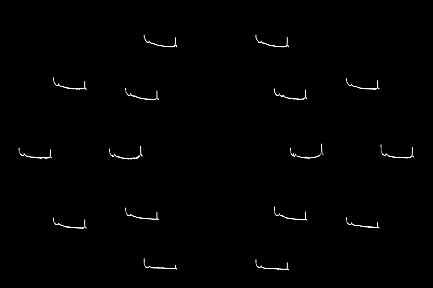

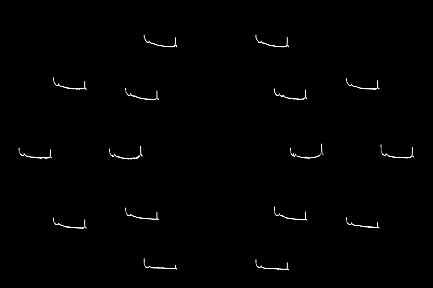

In [8]:
raw.plot_psd_topo(layout=layout)

Effective window size : 16.384 (s)


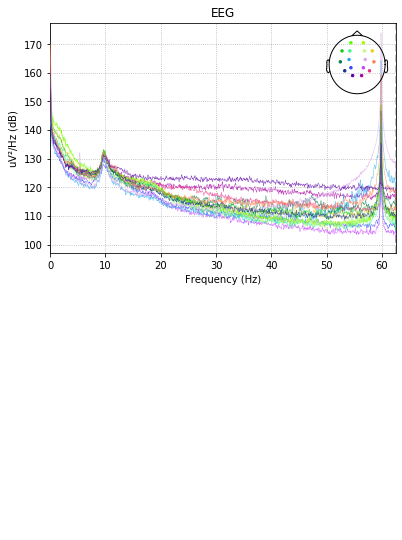

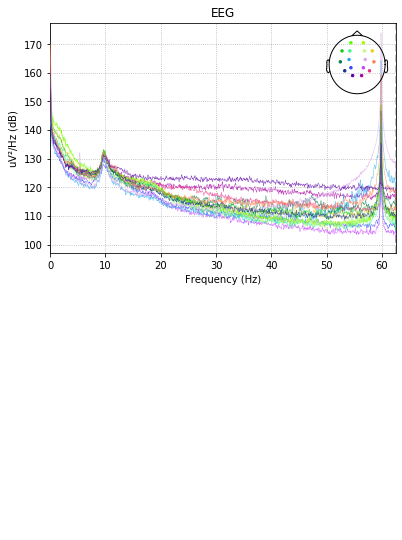

In [9]:
raw.plot_psd()

In [11]:
events = mne.find_events(raw, initial_event = False)

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
18 events found
Event IDs: [2 3 4 5 6 7]


In [14]:
    raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 825 samples (6.600 sec)



In [17]:
raw_highpass.plot?

Signature:
raw_highpass.plot(
    events=None,
    duration=10.0,
    start=0.0,
    n_channels=20,
    bgcolor='w',
    color=None,
    bad_color=(0.8, 0.8, 0.8),
    event_color='cyan',
    scalings=None,
    remove_dc=True,
    order=None,
    show_options=False,
    title=None,
    show=True,
    block=False,
    highpass=None,
    lowpass=None,
    filtorder=4,
    clipping=None,
    show_first_samp=False,
    proj=True,
    group_by='type',
    butterfly=False,
    decim='auto',
    noise_cov=None,
    event_id=None,
    show_scrollbars=True,
    verbose=None,
)
Docstring:
Plot raw data.

Parameters
----------
events : array | None
    Events to show with vertical bars.
duration : float
    Time window (s) to plot. The lesser of this value and the duration
    of the raw file will be used.
start : float
    Initial time to show (can be changed dynamically once plotted). If
    show_first_samp is True, then it is taken relative to
    ``raw.first_samp``.
n_channels : int
    Numbe

In [7]:
from scipy.sparse.sputils import isshape, isintlike, asmatrix, is_pydata_spmatrix

In [157]:
dir(scipy.sparse.sputils)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_upcast_memo',
 'absolute_import',
 'asmatrix',
 'bmat',
 'check_reshape_kwargs',
 'check_shape',
 'division',
 'downcast_intp_index',
 'get_index_dtype',
 'get_sum_dtype',
 'getdtype',
 'isdense',
 'isintlike',
 'ismatrix',
 'isscalarlike',
 'issequence',
 'isshape',
 'matrix',
 'np',
 'operator',
 'print_function',
 'supported_dtypes',
 'to_native',
 'upcast',
 'upcast_char',
 'upcast_scalar',
 'validateaxis',
 'warnings']

In [155]:
scipy.sparse.sputils.is_pydata_spmatrix

AttributeError: module 'scipy.sparse.sputils' has no attribute 'is_pydata_spmatrix'

In [156]:
print(scipy.sparse.sputils.__file__)

/home/sean/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py


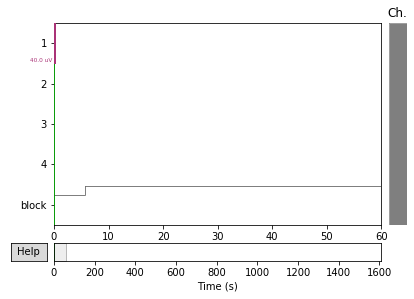

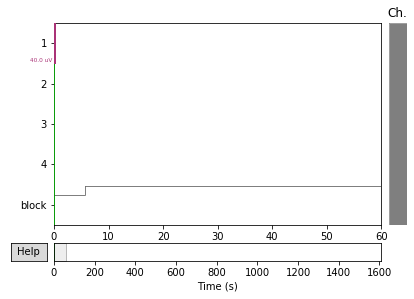

In [130]:
mag_channels = mne.pick_types(raw.info, eeg=True, stim=True)
raw.plot(duration=60, order=[0, 1, 2, 3, -1], n_channels=5,
         remove_dc=False)


Effective window size : 3.410 (s)


ImportError: cannot import name 'is_pydata_spmatrix' from 'scipy.sparse.sputils' (/home/sean/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py)

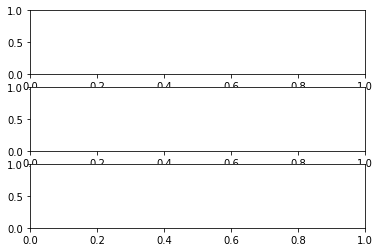

In [20]:
fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)
